In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle


In [2]:
# Path to the zip file
zip_file_path = 'archive(1).zip'

# Define the directory to extract the contents
extraction_folder = 'extracted_files'

# Ensure the extraction folder exists
os.makedirs(extraction_folder, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

# List the contents of the extracted folder
extracted_contents = os.listdir(extraction_folder)

# Show the extracted contents
extracted_contents


['Testing', 'Training']

In [ ]:
# categorical	--One-hot encoded labels	---Multi-class classification (3 or more categories)
# sparse	--- Integer labels (class indices)	-----Multi-class classification (3 or more categories)
# binary	----- Binary labels (0 or 1)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

extract_dir = 'extracted_files'
# Define the path to the extracted "Train" and "Test" folders
train_dir = os.path.join(extract_dir, 'Training')
test_dir = os.path.join(extract_dir, 'Testing')

# Set up ImageDataGenerator for training data with normalization and augmentation (if needed)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=40,           # Random rotations
    width_shift_range=0.2,       # Random horizontal shifts
    height_shift_range=0.2,      # Random vertical shifts
    shear_range=0.2,             # Random shearing
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flips          # Fill missing pixels after transformation
)

# Set up ImageDataGenerator for test data (just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data from the "Train" folder
train_generator = train_datagen.flow_from_directory(
    train_dir,                    # Path to training directory
    target_size=(224,224),       # Resize image
    batch_size=32,
    class_mode='categorical',     # Number of images per batch
    shuffle=True                  # Shuffle training data
)

# Load the test data from the "Test" folder
test_generator = test_datagen.flow_from_directory(
    test_dir,                     # Path to test directory
    target_size=(224,224),       # Resize image
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
# Get a batch of data from the train generator
images, labels = next(test_generator)

# Print the shape of the images batch
print("Shape of images batch:", images.shape)

# Print the shape of the labels batch
print("Shape of labels batch:", labels.shape)


Shape of images batch: (16, 224, 224, 3)
Shape of labels batch: (16, 4)


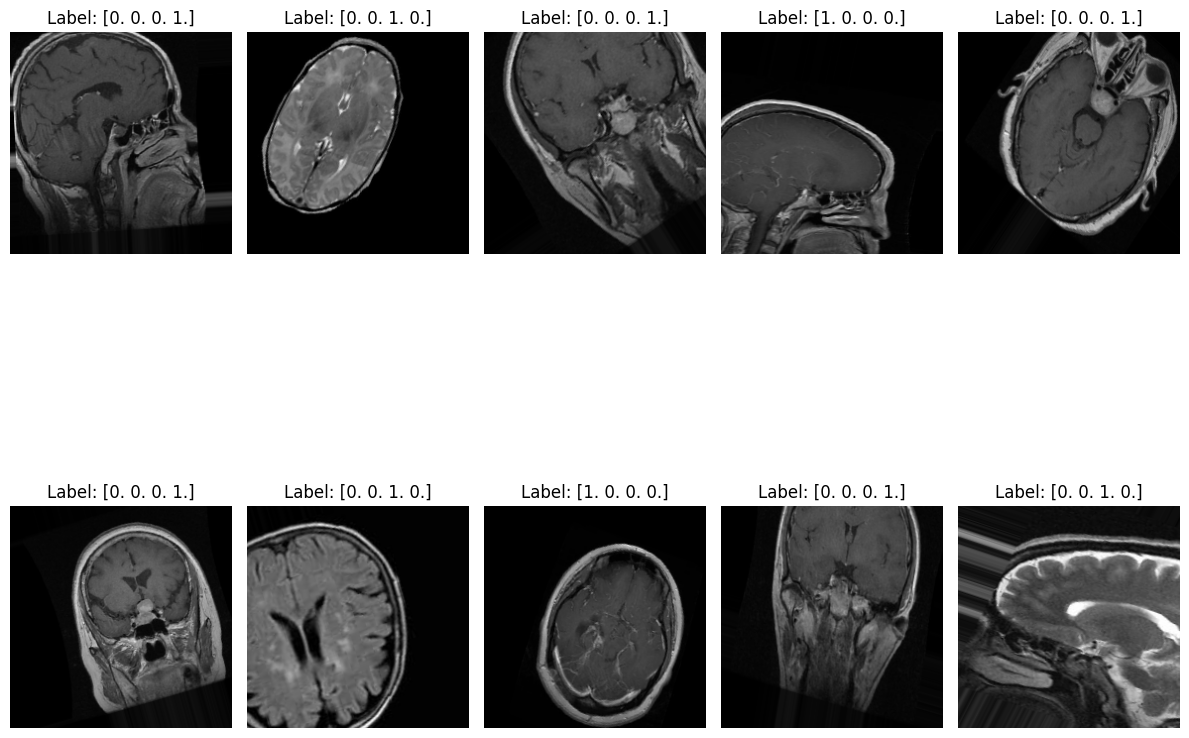

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the train generator
images, labels = next(train_generator)

# Plot the first 10 images in the batch
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns, place the images
    plt.imshow(images[i])    # Display the image
    plt.axis('off')          # Hide the axis
    plt.title(f"Label: {labels[i]}")  # Optionally display the label
plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all layers of VGG16 except the top ones (to retain pre-learned features)
for layer in base_model.layers:
    layer.trainable = False

# Build the model by adding custom fully connected layers on top of VGG16
model = models.Sequential()

# Add the VGG16 base model (pre-trained feature extractor)
model.add(base_model)

# Flatten the output from VGG16 to feed into the fully connected layers
model.add(layers.Flatten())

# Add fully connected layers
model.add(layers.Dense(1024, activation='relu'))  # adjust the number of units as needed
model.add(layers.Dropout(0.5))                    # Dropout for regularization
model.add(layers.Dense(512, activation='relu'))   # Another dense layer
model.add(layers.Dropout(0.5))                    # Dropout layer for regularization
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Use a smaller learning rate for transfer learning
              loss='categorical_crossentropy',       # For multi-class classification
              metrics=['accuracy'])

# Summarize the model architecture
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,932,676 (156.15 MB)

 Trainable params: 26,217,988 (100.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
history = model.fit(
    train_generator,                           # Training data generator
    epochs=10,                                 # Number of epochs
    validation_data=test_generator,            # Validation data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    validation_steps=test_generator.samples // test_generator.batch_size,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 115s 558ms/step - accuracy: 0.4606 - loss: 1.2953 - val_accuracy: 0.7176 - val_loss: 0.7540
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - accuracy: 0.5312 - loss: 0.9445

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5312 - loss: 0.9445 - val_accuracy: 0.7191 - val_loss: 0.7527
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 143s 804ms/step - accuracy: 0.7048 - loss: 0.7147 - val_accuracy: 0.7647 - val_loss: 0.6351
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.4375 - loss: 1.0779 - val_accuracy: 0.7670 - val_loss: 0.6277
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 142s 515ms/step - accuracy: 0.7599 - loss: 0.6092 - val_accuracy: 0.8032 - val_loss: 0.5369
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8438 - loss: 0.4522 - val_accuracy: 0.7994 - val_loss: 0.5469
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 142s 798ms/step - accuracy: 0.7799 - loss: 0.5667 - val_accuracy: 0.7554 - val_loss: 0.6344
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8750 - loss: 0.3510 - val_accuracy: 0.7523 - val_loss: 0.6364
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 144s 532ms/step - accuracy: 0.8107 - loss: 0.4880 - val_a

In [9]:
from sklearn.metrics import accuracy_score

#Predict on the test set
test_pred = model.predict(test_generator)

# Convert the predicted probabilities to class labels
test_pred_classes = np.argmax(test_pred, axis=1)

# Get the true class labels
true_classes = test_generator.classes

#Calculate accuracy score
accuracy = accuracy_score(true_classes, test_pred_classes)

# Print the accuracy score as a percentage
print(f"Test Accuracy: {accuracy * 100:.2f}%")


82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step
Test Accuracy: 78.18%


In [10]:
from sklearn.metrics import classification_report

print(classification_report(true_classes,test_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.67      0.78       300
           1       0.72      0.44      0.55       306
           2       0.87      0.96      0.91       405
           3       0.66      1.00      0.79       300

    accuracy                           0.78      1311
   macro avg       0.79      0.77      0.76      1311
weighted avg       0.80      0.78      0.77      1311



# Testing

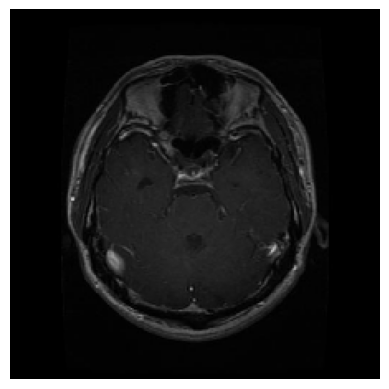

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Class: glioma


In [14]:
from tensorflow.keras.preprocessing import image

# Function to preprocess, visualize and predict the class of a single image
def predict_image(img_path, model, class_names=None):
    # Load the image from the file
    img = image.load_img(img_path, target_size=(224,224))  # Resize to match the input size of the model

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Rescale the image to [0, 1]
    img_array = img_array / 255.0

    # Reshape the image
    img_array = img_array.reshape(1, 224,224, 3)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # with class names provided, map the index to the class name
    if class_names:
        predicted_class_name = class_names[predicted_class_index]
    else:
        predicted_class_name = str(predicted_class_index)

    return predicted_class_name

img_path = 'image.jpg'
class_names = ['glioma','meningioma','notumor','pituitary']
predicted_class_name = predict_image(img_path, model, class_names)

print(f'Predicted Class: {predicted_class_name}')


# The model has predicted the image correctly as Glioma.